In [4]:
# ============================================================================
# CONFIGURATION
# This cell contains all the settings a user needs to change.
# ============================================================================

# --- PATHS ---
# TODO: Update these paths to point to your project folders.
# This file should contain your complete data with no missing values.
GROUND_TRUTH_FILE = "/users/aranpurdy/desktop/GIT/MAN_imputed_data/Ground_Truth_Imputed.xlsx"

# This directory should contain the datasets with artificial missingness (mcar_data.xlsx, etc.).
ARTIFICIAL_MISSINGNESS_DIR = "/users/aranpurdy/desktop/GIT/ArtificialMissingness"

# This directory should contain your imputation results files (mcar_imputed.xlsx, etc.).
IMPUTATION_RESULTS_DIR = "/users/aranpurdy/desktop/GIT/Imputomics_Results"

# The directory where the performance plots will be saved.
OUTPUT_PLOTS_DIR = "output/Performance_Plots"


# --- DATA FORMAT ---
# Set to True if your data files have samples as columns and metabolites as rows.
# Set to False if they already have samples as rows.
TRANSPOSE_DATA = True

# --- ANALYSIS CONFIGURATION ---
# This dictionary maps missingness patterns to their respective input files.
# The script will automatically discover the imputation methods from the sheets
# in the results files, IGNORING THE FIRST SHEET.
ANALYSIS_CONFIG = {
    "MCAR": {
        "missing_data_file": "mcar_data.xlsx",
        "imputed_results_file": "mcar_imputed.xlsx"
    },
    "MAR": {
        "missing_data_file": "mar_data.xlsx",
        "imputed_results_file": "mar_imputed.xlsx"
    },
    "MNAR": {
        "missing_data_file": "mnar_data.xlsx",
        "imputed_results_file": "mnar_imputed.xlsx"
    }
}

In [5]:
# ============================================================================
# SCRIPT LOGIC (Functions)
# This cell contains the core logic of the script.
# A user typically does not need to edit this cell.
# ============================================================================
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Union, Tuple

# --- Helper Functions ---
# (These functions remain the same as before)
def calculate_nrmse(true_values: np.ndarray, imputed_values: np.ndarray, original_range: Tuple[float, float]) -> float:
    """Calculates Normalized Root Mean Squared Error (NRMSE)."""
    if true_values.size == 0: return np.nan
    rmse = np.sqrt(np.mean((imputed_values - true_values)**2))
    data_range = original_range[1] - original_range[0]
    return rmse / data_range if data_range != 0 else 0.0

def calculate_mae(true_values: np.ndarray, imputed_values: np.ndarray) -> float:
    """Calculates Mean Absolute Error (MAE)."""
    if true_values.size == 0: return np.nan
    return np.mean(np.abs(imputed_values - true_values))

def check_for_negative_values(df_imputed: pd.DataFrame) -> int:
    """Checks for the presence of negative values in the imputed DataFrame."""
    numeric_df = df_imputed.select_dtypes(include=np.number)
    return (numeric_df < 0).sum().sum()

def load_and_prepare_df(data: Union[str, pd.DataFrame], transpose: bool) -> Union[pd.DataFrame, None]:
    """Loads and optionally transposes a dataframe, sanitizing column names."""
    try:
        # Check if the input is a file path or an already loaded DataFrame
        if isinstance(data, str):
            df_raw = pd.read_excel(data, na_values=['', ' ', '-', '#N/A', 'NULL', 'null'])
            filename_for_log = os.path.basename(data)
        else:
            df_raw = data
            filename_for_log = "a DataFrame sheet"

        if transpose:
            if df_raw.iloc[:, 0].nunique() == len(df_raw):
                df = df_raw.set_index(df_raw.columns[0]).T
            else:
                print(f"  Warning: First column of {filename_for_log} is not unique. Transposing with default index.")
                df = df_raw.T
        else:
            df = df_raw

        # Sanitize column and index names for easier matching
        df.columns = [str(col).replace('.', '_').replace(' ', '_') for col in df.columns]
        df.index = [str(idx).replace('.', '_').replace(' ', '_') for idx in df.index]
        return df
    except FileNotFoundError:
        print(f"  ERROR: File not found at '{data}'.")
        return None
    except Exception as e:
        print(f"  ERROR: Could not load or process file '{data}'. Details: {e}")
        return None

# --- Main Pipeline Function ---

def run_performance_analysis(ground_truth_file, missing_dir, results_dir, output_dir, transpose, config):
    """Orchestrates the entire performance analysis pipeline."""
    print("--- Starting Imputation Performance Analysis ---")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load ground truth data
    print(f"\n1. Loading ground truth data...")
    df_true = load_and_prepare_df(ground_truth_file, transpose)
    if df_true is None: return

    numeric_cols = df_true.select_dtypes(include=np.number).columns.tolist()
    if not numeric_cols:
        print("ERROR: No numeric columns found in the ground truth data. Exiting.")
        return
        
    global_min = df_true[numeric_cols].min().min()
    global_max = df_true[numeric_cols].max().max()
    global_range = (global_min, global_max)
    print(f"  Found {len(numeric_cols)} numeric features. Global data range for NRMSE: [{global_min:.2f}, {global_max:.2f}]")

    all_results = []
    negative_value_counts = []

    # 2. Iterate through each missingness pattern
    for pattern_type, pattern_config in config.items():
        print(f"\n2. Analyzing pattern: {pattern_type}")
        
        missing_data_path = os.path.join(missing_dir, pattern_config["missing_data_file"])
        df_missing = load_and_prepare_df(missing_data_path, transpose)
        if df_missing is None: continue

        imputed_results_path = os.path.join(results_dir, pattern_config["imputed_results_file"])
        try:
            imputed_sheets = pd.read_excel(imputed_results_path, sheet_name=None)
        except FileNotFoundError:
            print(f"  ERROR: Imputed results file not found for {pattern_type}: {imputed_results_path}. Skipping.")
            continue
        
        # --- NEW LOGIC TO HANDLE SHEET STRUCTURE ---
        sheet_names = list(imputed_sheets.keys())
        if len(sheet_names) < 2:
            print(f"  WARNING: Imputed results file for {pattern_type} has fewer than 2 sheets. Skipping evaluation.")
            continue
        
        # Get all sheets EXCEPT the first one
        imputed_sheet_names = sheet_names[1:]
        print(f"  Found {len(imputed_sheet_names)} imputed results sheets to evaluate: {', '.join(imputed_sheet_names)}")
        # --- END OF NEW LOGIC ---

        common_samples = df_true.index.intersection(df_missing.index)
        common_cols = df_true.columns.intersection(df_missing.columns).intersection(numeric_cols)
        
        df_true_aligned = df_true.loc[common_samples, common_cols]
        df_missing_aligned = df_missing.loc[common_samples, common_cols]
        is_missing_mask = df_missing_aligned.isna()

        # 3. Evaluate each imputation method by iterating through the discovered sheets
        for method_name in imputed_sheet_names:
            print(f"  - Evaluating method: '{method_name}'")
            
            # Get the dataframe for the current sheet
            df_imputed_raw = imputed_sheets[method_name]
            df_imputed = load_and_prepare_df(df_imputed_raw, transpose)
            if df_imputed is None: continue
                
            df_imputed_aligned = df_imputed.loc[common_samples, common_cols].apply(pd.to_numeric, errors='coerce')

            true_vals = df_true_aligned.where(is_missing_mask).values.flatten()
            imputed_vals = df_imputed_aligned.where(is_missing_mask).values.flatten()
            
            valid_mask = ~np.isnan(true_vals) & ~np.isnan(imputed_vals)
            true_vals = true_vals[valid_mask]
            imputed_vals = imputed_vals[valid_mask]
            
            all_results.append({
                "Missingness Pattern": pattern_type,
                "Method": method_name,
                "NRMSE": calculate_nrmse(true_vals, imputed_vals, global_range),
                "MAE": calculate_mae(true_vals, imputed_vals)
            })
            
            negative_value_counts.append({
                "Missingness Pattern": pattern_type,
                "Method": method_name,
                "Negative Values": check_for_negative_values(df_imputed_aligned)
            })

    # 4. Generate and save plots (This part remains the same)
    if not all_results:
        print("\nERROR: No results were generated. Cannot create plots.")
        return

    print("\n3. Generating performance plots...")
    results_df = pd.DataFrame(all_results)
    
    plt.figure(figsize=(16, 8))
    sns.barplot(data=results_df, x="Method", y="NRMSE", hue="Missingness Pattern", palette="viridis")
    plt.title("NRMSE of Imputation Methods (Lower is Better)", fontsize=16)
    plt.ylabel("NRMSE", fontsize=12)
    plt.xlabel("Imputation Method", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Missingness Type")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "nrmse_performance_plot.png"), dpi=300)
    plt.show()

    plt.figure(figsize=(16, 8))
    sns.barplot(data=results_df, x="Method", y="MAE", hue="Missingness Pattern", palette="magma")
    plt.title("MAE of Imputation Methods (Lower is Better)", fontsize=16)
    plt.ylabel("MAE", fontsize=12)
    plt.xlabel("Imputation Method", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Missingness Type")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "mae_performance_plot.png"), dpi=300)
    plt.show()

    neg_values_df = pd.DataFrame(negative_value_counts)
    if neg_values_df["Negative Values"].sum() > 0:
        plt.figure(figsize=(16, 8))
        sns.barplot(data=neg_values_df, x="Method", y="Negative Values", hue="Missingness Pattern", palette="coolwarm")
        plt.title("Count of Negative Values Introduced by Imputation", fontsize=16)
        plt.ylabel("Count of Negative Values", fontsize=12)
        plt.xlabel("Imputation Method", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Missingness Type")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "negative_values_plot.png"), dpi=300)
        plt.show()
    
    print(f"  Performance plots saved to '{output_dir}'.")
    print("\n--- Pipeline Finished ---")

--- Starting Imputation Performance Analysis ---

1. Loading ground truth data...
  Found 64 numeric features. Global data range for NRMSE: [35632.90, 341000000.00]

2. Analyzing pattern: MCAR
  Found 5 imputed results sheets to evaluate: bpca, eucknn, missmda em, ppca, metabimpute rf
  - Evaluating method: 'bpca'
  - Evaluating method: 'eucknn'
  - Evaluating method: 'missmda em'
  - Evaluating method: 'ppca'
  - Evaluating method: 'metabimpute rf'

2. Analyzing pattern: MAR
  Found 5 imputed results sheets to evaluate: bpca, missmda em, ppca, metabimpute rf, svd
  - Evaluating method: 'bpca'
  - Evaluating method: 'missmda em'
  - Evaluating method: 'ppca'
  - Evaluating method: 'metabimpute rf'
  - Evaluating method: 'svd'

2. Analyzing pattern: MNAR
  Found 6 imputed results sheets to evaluate: cm, halfmin, metabimpute halfmin, knn, metabimpute min, min
  - Evaluating method: 'cm'
  - Evaluating method: 'halfmin'
  - Evaluating method: 'metabimpute halfmin'
  - Evaluating method: '

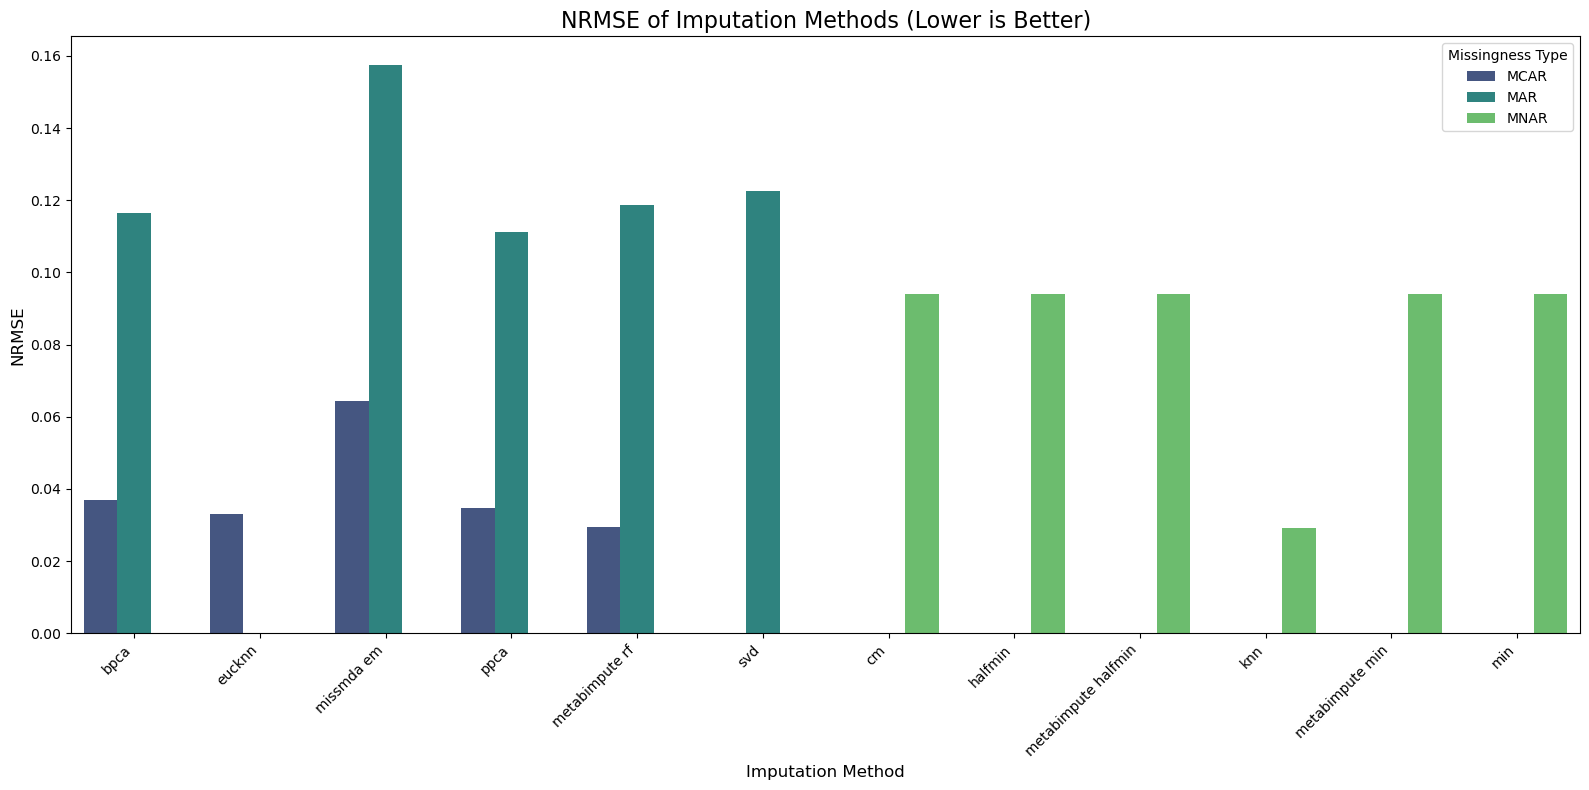

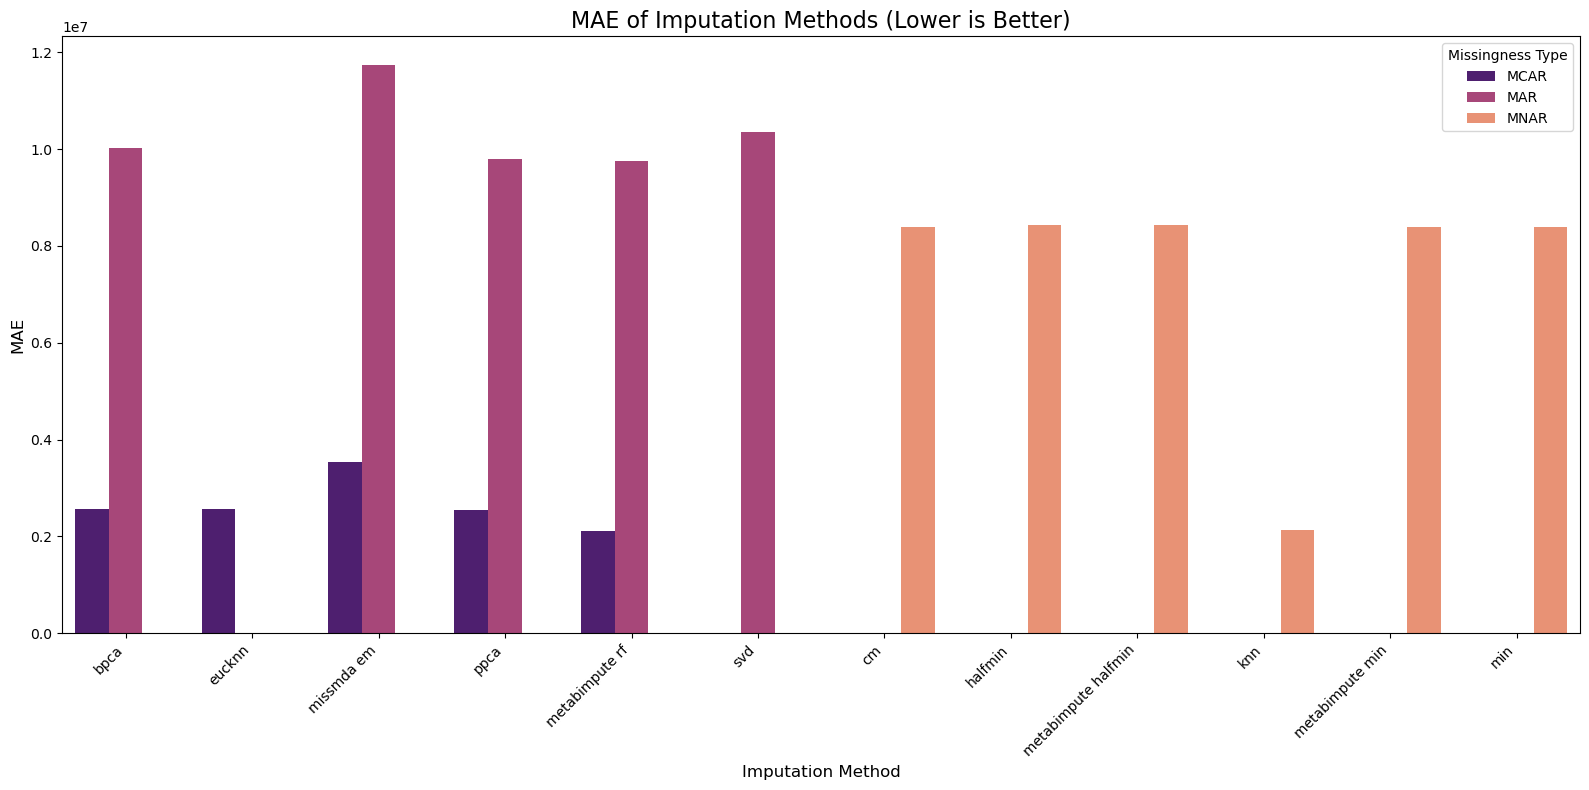

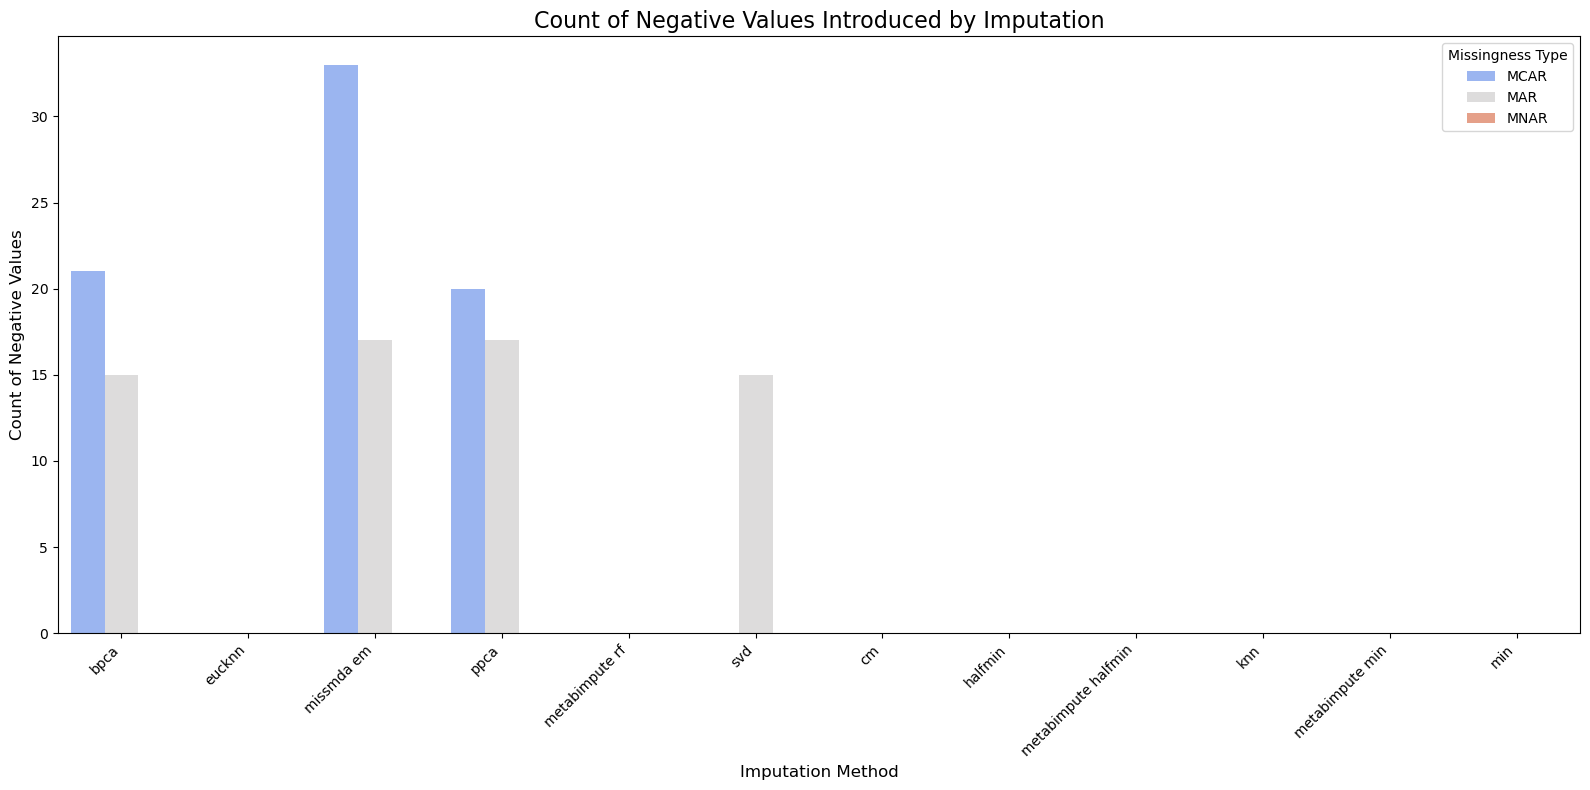

  Performance plots saved to 'output/Performance_Plots'.

--- Pipeline Finished ---


In [6]:
# ============================================================================
# EXECUTION
# This cell calls the main function using the variables from the Configuration cell.
# ============================================================================

run_performance_analysis(
    ground_truth_file=GROUND_TRUTH_FILE,
    missing_dir=ARTIFICIAL_MISSINGNESS_DIR,
    results_dir=IMPUTATION_RESULTS_DIR,
    output_dir=OUTPUT_PLOTS_DIR,
    transpose=TRANSPOSE_DATA,
    config=ANALYSIS_CONFIG
)